In [1]:
import pandas as pd
import numpy as np
from os import path

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline
data_frame = pd.read_csv('data/Entrenamieto_ECI_2020.csv')

In [2]:
data_frame["Opportunity_Created_Date"] = pd.to_datetime(data_frame["Opportunity_Created_Date"], errors="coerce")
data_frame["Planned_Delivery_Start_Date"] = pd.to_datetime(data_frame["Planned_Delivery_Start_Date"], errors="coerce")
data_frame["Planned_Delivery_End_Date"] = pd.to_datetime(data_frame["Planned_Delivery_End_Date"], errors="coerce")
data_frame["Quote_Expiry_Date"] = pd.to_datetime(data_frame["Quote_Expiry_Date"], errors="coerce")
data_frame["Last_Modified_Date"] = pd.to_datetime(data_frame["Last_Modified_Date"], errors="coerce")
data_frame["Account_Created_Date"] = pd.to_datetime(data_frame["Account_Created_Date"], errors="coerce")


dateColumns = ["Opportunity_Created_Date", "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Quote_Expiry_Date", "Last_Modified_Date", "Account_Created_Date"]

grouped = data_frame.groupby(['Opportunity_Name', 'Opportunity_Created_Date', "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Stage"]).agg({"Territory": "count"}).reset_index()

In [3]:
grouped = grouped.drop(8401)
grouped.filter(grouped["Opportunity_Created_Date"] < grouped["Planned_Delivery_Start_Date"])
grouped["delay"] = grouped['Planned_Delivery_Start_Date'].sub(grouped['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
grouped["delay_over_mean"] = grouped["delay"] > grouped["delay"].mean()
grouped.loc[grouped["delay_over_mean"] == True].Stage.value_counts()

Closed Lost      2844
Closed Won       1053
Proposal           28
Qualification       9
Negotiation         6
Name: Stage, dtype: int64

In [4]:
#WIN-RATE BY TERRITORY
closed = data_frame[data_frame["Stage"].str.contains("Closed")]
groupedTerritory = closed.groupby(['Opportunity_Name', "Region", "Territory", "Stage"]).agg({"ID": "count"}).reset_index()
groupedTerritory = groupedTerritory.groupby(["Region", "Stage"]).agg({"ID": "count"})
groupedTerritory = groupedTerritory.pivot_table(columns="Stage", index="Region", values="ID", aggfunc="sum")
groupedTerritory["Closed Won"] = groupedTerritory["Closed Won"].fillna(0)
groupedTerritory["Closed Lost"] = groupedTerritory["Closed Lost"].fillna(0)
groupedTerritory["win_rate_territory"] = groupedTerritory["Closed Won"] / (groupedTerritory["Closed Won"] + groupedTerritory["Closed Lost"])
groupedTerritory.nlargest(20, "win_rate_territory")



Stage,Closed Lost,Closed Won,win_rate_territory
Region,,,
Japan,595,1290,0.684350
APAC,924,1155,0.555556
EMEA,1737,1500,0.463392
Americas,1358,1094,0.446166
Middle East,105,33,0.239130


In [5]:
#TODOS LOS BRAND DISTINTOS DE NONE Y OTHER SON LOST
notNone = data_frame[(data_frame["Brand"] != "None")]
notNone.Stage.value_counts()
#data_frame["Brand"].value_counts()

Closed Lost    1036
Name: Stage, dtype: int64

Text(0, 0.5, 'Win Rate')

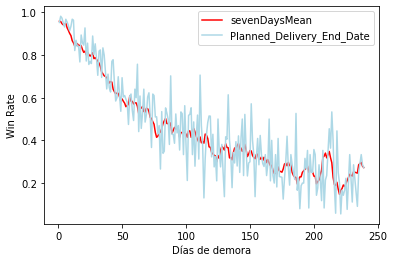

In [6]:
#RELACION WINRATE TIEMPO DEMORA

grouped = grouped[grouped["Opportunity_Created_Date"] < grouped["Planned_Delivery_End_Date"]]
grouped["delay"] = grouped['Planned_Delivery_End_Date'].sub(grouped['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
#grouped.plot(kind='scatter', x='delay', y='Stage', color='red')
s = grouped.groupby(["delay", "Stage"]).agg({"Planned_Delivery_End_Date":"count"}).reset_index()
se = s.groupby(["delay"]).apply(lambda x: x[x.Stage=="Closed Won"]['Planned_Delivery_End_Date'] / x['Planned_Delivery_End_Date'].sum()).reset_index()
se = se[se["delay"] < 240]

meanDelay = []
rangei = 0
rangef = 7

for i in range(len(se["Planned_Delivery_End_Date"])):
    val = 0
    if (rangef > len(se["Planned_Delivery_End_Date"])):
        rangef -= 1
    for j in range (rangei, rangef):
        val += se["Planned_Delivery_End_Date"][j]
    meanDelay.append(val / (rangef - rangei) )
    rangei = rangei + 1
    rangef = rangef + 1
se["sevenDaysMean"] = pd.Series(meanDelay)
ax = se.plot(x='delay', y="sevenDaysMean", kind= "line", color='red')
se.plot(x='delay', y='Planned_Delivery_End_Date', kind= "line", color='lightblue', ax=ax)
ax.set_xlabel("Días de demora")
ax.set_ylabel("Win Rate")

<AxesSubplot:xlabel='duracionPresupuesto'>

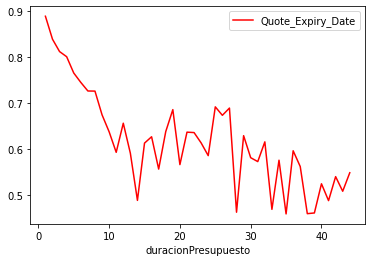

In [7]:
#WINRATE RELACION DURACION PRESUPUESTO

groupedPresupuesto = data_frame.groupby(['Opportunity_Name','Opportunity_Created_Date', 'Quote_Expiry_Date', "Quote_Type", "Stage"]).agg({"Territory": "count"}).reset_index()
groupedPresupuesto = groupedPresupuesto[groupedPresupuesto['Quote_Expiry_Date'] > groupedPresupuesto['Opportunity_Created_Date']]
groupedPresupuesto["duracionPresupuesto"] = groupedPresupuesto['Quote_Expiry_Date'].sub(groupedPresupuesto['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')


s1 = groupedPresupuesto.groupby(["duracionPresupuesto", "Stage"]).agg({"Quote_Expiry_Date":"count"}).reset_index()
se2 = s1.groupby(["duracionPresupuesto"]).apply(lambda x: x[x.Stage=="Closed Won"]['Quote_Expiry_Date'] / x['Quote_Expiry_Date'].sum()).reset_index()
se2 = se2[se2["duracionPresupuesto"] < 45]

se2.plot(x='duracionPresupuesto', y="Quote_Expiry_Date", kind= "line", color='red')

#groupedPresupuesto.groupby(['duracionPresupuesto',"Quote_Type"]).count()


In [8]:
#PRODUCTOS POR OPORTUNIDAD // QUOTE TYPE

productsByOpportunity = data_frame.groupby(['Opportunity_Name', 'Stage']).agg({"ID":"count"}).reset_index()
productsByOpportunity.columns = ["Opportunity_Name", "Resultado", "Cantidad"]
productsByOpportunity.groupby("Cantidad")

data_frame.Quote_Expiry_Date.isnull().value_counts()
data_frame[data_frame["Quote_Type"] == "Binding"].Stage.value_counts()


Closed Won     86
Closed Lost    84
Name: Stage, dtype: int64

<ipython-input-9-697f3719fb24>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correctDates["daysInSystemBeforeOpportunity"] = np.floor(correctDates["Opportunity_Created_Date"].sub(correctDates["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'M'))


<AxesSubplot:xlabel='daysInSystemBeforeOpportunity'>

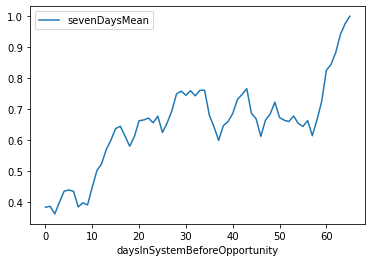

In [9]:
#RELACION WIN RATE CON MESES EN LA PLATAFORMA

correctDates = data_frame[data_frame["Account_Created_Date"] <= data_frame["Opportunity_Created_Date"]]
correctDates["daysInSystemBeforeOpportunity"] = np.floor(correctDates["Opportunity_Created_Date"].sub(correctDates["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'M'))
correctDates["daysInSystemBeforeOpportunity"].value_counts()

grp = correctDates.groupby(["daysInSystemBeforeOpportunity", "Stage"]).agg({"ID": "count"}).reset_index()
grp = grp.groupby(["daysInSystemBeforeOpportunity"]).apply(lambda x: x[x.Stage=="Closed Won"]['ID'] / x['ID'].sum()).reset_index()

meanDelay = []
rangei = 0
rangef = 3

for i in range(len(grp["ID"])):
    val = 0
    if (rangef > len(grp["ID"])):
        rangef -= 1
    for j in range (rangei, rangef):
        val += grp["ID"][j]
    meanDelay.append(val / (rangef - rangei) )
    rangei = rangei + 1
    rangef = rangef + 1
grp["sevenDaysMean"] = pd.Series(meanDelay)

#ax = correctDates["daysInSystemBeforeOpportunity"].plot.hist(bins=60, color="lightblue")
grp.plot(x="daysInSystemBeforeOpportunity", y="sevenDaysMean", kind="line")



<AxesSubplot:>

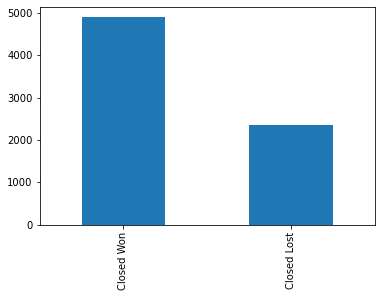

In [10]:
#RANGO DE DELIVERY
#FILTRAR CLOSED
data_frame["Delivery_Range"] = data_frame["Planned_Delivery_End_Date"].sub(data_frame["Planned_Delivery_Start_Date"], axis=0)/ np.timedelta64(1, 'D')
closedOpportunities = data_frame[data_frame["Stage"].str.contains("Closed")]
#largestDeliveryRange = data_frame[closedOpportunities["Delivery_Range"] > 0]
#largestDeliveryRange.Stage.value_counts().plot.bar()

smallestDeliveryRange = closedOpportunities[closedOpportunities["Delivery_Range"] == 0]
smallestDeliveryRange.Stage.value_counts().plot.bar()


In [11]:
data_frame[data_frame["Opportunity_Name"] == "Opportunity_Name_112"].T


,9067
ID,28250
Region,Americas
Territory,SW America
"Pricing, Delivery_Terms_Quote_Appr",1
"Pricing, Delivery_Terms_Approved",0
Bureaucratic_Code_0_Approval,0
Bureaucratic_Code_0_Approved,0
Submitted_for_Approval,0
Bureaucratic_Code,Bureaucratic_Code_5
Account_Created_Date,2015-07-30 00:00:00


<AxesSubplot:>

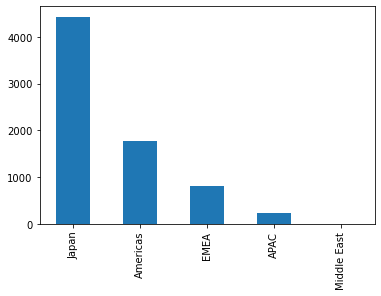

In [12]:
smallestDeliveryRange["Region"].value_counts().plot.bar()

<AxesSubplot:>

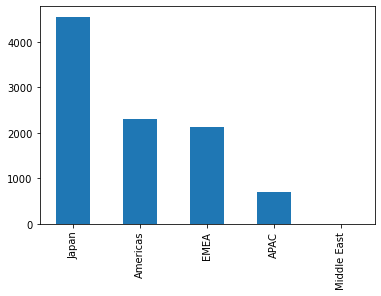

In [13]:
data_frame["Delivery_Range"] = data_frame["Planned_Delivery_End_Date"].sub(data_frame["Planned_Delivery_Start_Date"], axis=0)/ np.timedelta64(1, 'D')
closedOpportunities = data_frame[data_frame["Stage"].str.contains("Closed")]
largestDeliveryRange = closedOpportunities[closedOpportunities["Delivery_Range"] < 7]
largestDeliveryRange["Region"].value_counts().plot.bar()

<AxesSubplot:xlabel='Region'>

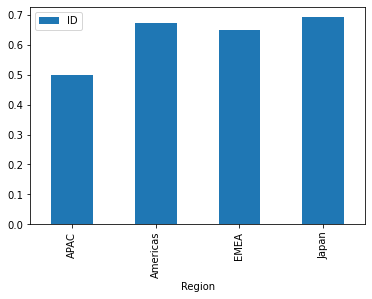

In [14]:
smallestByRegion = smallestDeliveryRange.groupby(["Region", "Stage"]).agg({"ID":"count"}).reset_index()
smallestWinRate = smallestByRegion.groupby("Region").apply(lambda x: x[x.Stage=="Closed Won"]['ID'] / x['ID'].sum()).reset_index()
smallestWinRate.plot(x="Region", y="ID", kind="bar")

In [15]:
#EN SOURCE HAY ALGO
notNullSource = data_frame[data_frame['Source '] != "None"]
notNullSource.Stage.value_counts()

Closed Won       4083
Closed Lost      3346
Proposal           12
Negotiation         7
Qualification       2
Name: Stage, dtype: int64

In [16]:
data_frame[data_frame["Opportunity_Owner"] != data_frame["Account_Owner"]].head(4).T

,0,1,2,7
ID,27761,27760,27446,27455
Region,EMEA,EMEA,Americas,Americas
Territory,None,None,NW America,NW America
"Pricing, Delivery_Terms_Quote_Appr",1,0,0,1
"Pricing, Delivery_Terms_Approved",1,0,0,1
Bureaucratic_Code_0_Approval,1,0,0,1
Bureaucratic_Code_0_Approved,1,0,0,1
Submitted_for_Approval,0,0,0,0
Bureaucratic_Code,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4,Bureaucratic_Code_4
Account_Created_Date,2015-06-16 00:00:00,2015-06-16 00:00:00,2015-04-21 00:00:00,2015-04-21 00:00:00


In [17]:
opportunitiesBySeller = data_frame.groupby(["Opportunity_Owner"]).agg({"Opportunity_ID": pd.Series.nunique})
#opportunitiesBySeller.nlargest(10, "Opportunity_ID").plot.barh()
sarasa = data_frame.groupby(["Opportunity_Name", "Opportunity_Owner", "Total_Taxable_Amount", "Stage"]).agg({"Opportunity_ID": pd.Series.nunique}).reset_index()
meanAmountBySeller = sarasa.groupby("Opportunity_Owner").agg({"Total_Taxable_Amount": "mean", "Opportunity_ID":"count"}).reset_index()

<AxesSubplot:xlabel='winrate', ylabel='Quantity'>

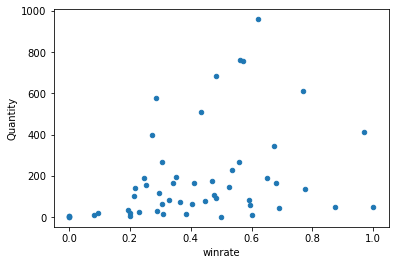

In [18]:
winRateBySeller = sarasa.groupby(["Opportunity_Owner"]).apply(lambda x: len(x[x.Stage=="Closed Won"]) / len(x)).reset_index()

merged = winRateBySeller.merge(meanAmountBySeller, on="Opportunity_Owner")
merged.columns = ['Opportunity_Owner', "winrate", 'Total_Taxable_Amount', 'Quantity']
merged.plot(x="winrate", y="Quantity", kind="scatter")

In [19]:
data_frame.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source ',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currenc

<AxesSubplot:title={'center':'10 familias de producto mas recurrentes'}>

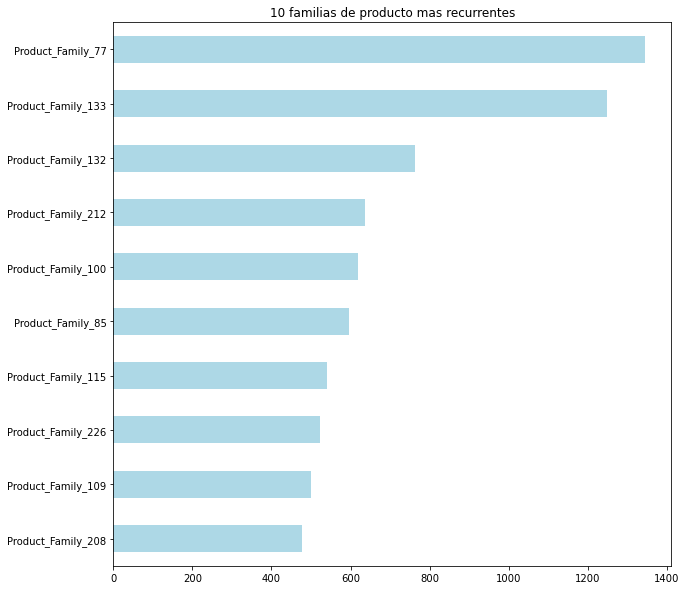

In [68]:
df_family = data_frame['Product_Family'].value_counts().nlargest(10)
df_family.sort_values(ascending=True).plot.barh(title='10 familias de producto mas recurrentes', figsize=(10,10), color='lightblue')

<AxesSubplot:title={'center':'mayor cantidad de familias de productos distintas vendidas por un vendedor (top 10)'}, xlabel='Opportunity_Owner'>

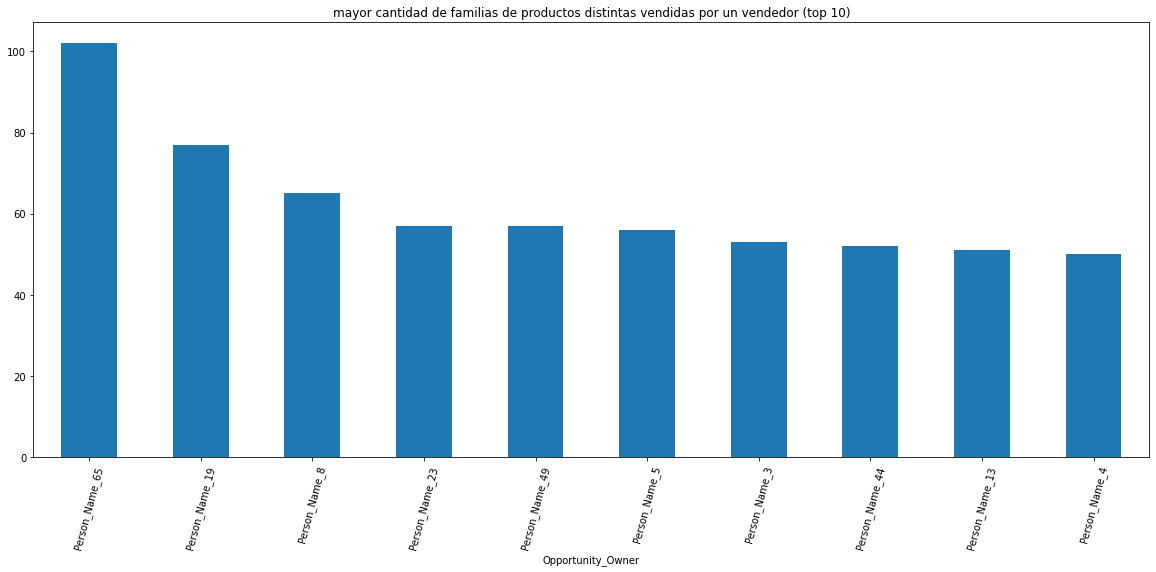

In [83]:
opportunitiesByFamily = data_frame.groupby(['Opportunity_Owner']).agg({'Opportunity_ID':pd.Series.nunique,'Product_Family':pd.Series.nunique})
opportunitiesByFamily.columns = ['Opportunity_count', 'Product_Family_count']
opportunitiesByFamily.reset_index().sort_values(by='Product_Family_count',ascending=False).nlargest(10,columns='Product_Family_count').plot.bar(legend=False,figsize=(20,8),rot=75,x='Opportunity_Owner', y='Product_Family_count',title='mayor cantidad de familias de productos distintas vendidas por un vendedor (top 10)')

<AxesSubplot:title={'center':'mayor cantidad de vendedores distintos por familia de producto (top 10)'}, xlabel='Product_Family'>

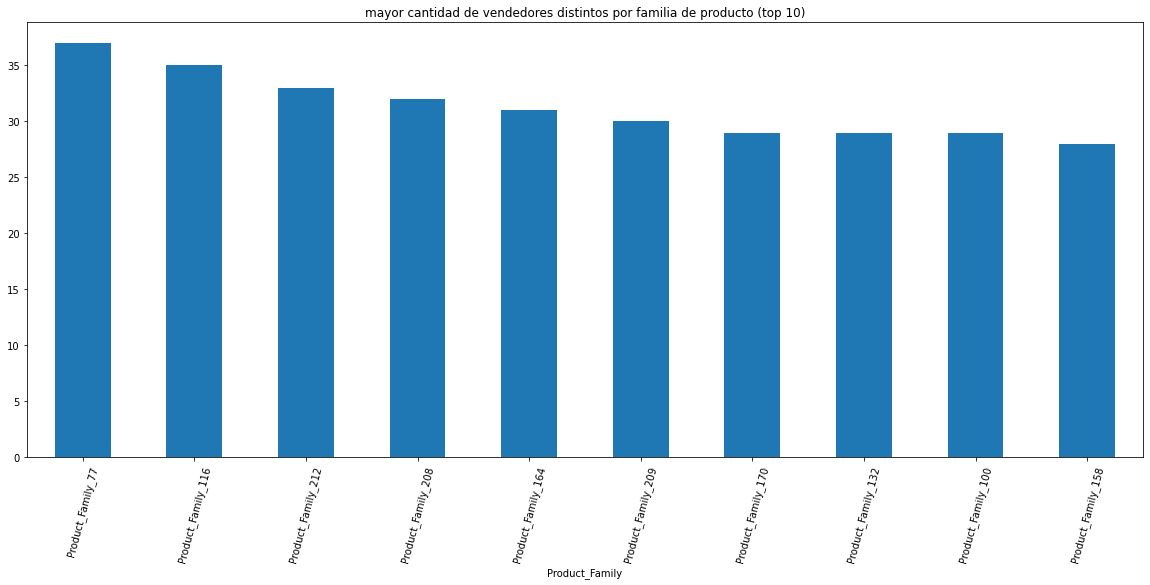

In [82]:
opportunitiesByFamily = data_frame.groupby(['Product_Family']).agg({'Opportunity_ID':pd.Series.nunique,'Opportunity_Owner':pd.Series.nunique})
opportunitiesByFamily.columns = ['Opportunity_count', 'Owner_count']
opportunitiesByFamily.reset_index().sort_values(by='Owner_count',ascending=False).nlargest(10,columns='Owner_count').plot.bar(legend=False,figsize=(20,8),rot=75,x='Product_Family', y='Owner_count',title='mayor cantidad de vendedores distintos por familia de producto (top 10)')

<AxesSubplot:title={'center':'Vendedores con mayor cantidad de regiones'}, xlabel='Opportunity_Owner'>

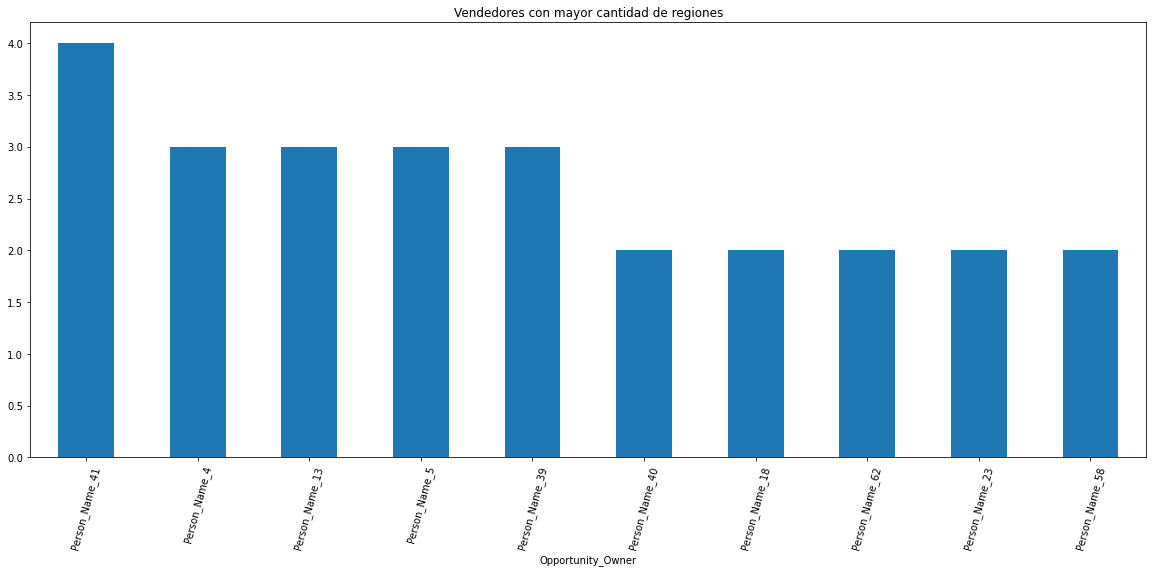

In [85]:
opportunitiesByFamily = data_frame.groupby(['Opportunity_Owner']).agg({'Opportunity_ID':pd.Series.nunique,'Region':pd.Series.nunique})
opportunitiesByFamily.columns = ['Opportunity_count', 'Region_count']
opportunitiesByFamily.reset_index().sort_values(by='Region_count',ascending=False).nlargest(10,columns='Region_count').plot\
.bar(legend=False,figsize=(20,8),rot=75,x='Opportunity_Owner', y='Region_count',title='Vendedores con mayor cantidad de regiones')

<AxesSubplot:xlabel='Region'>

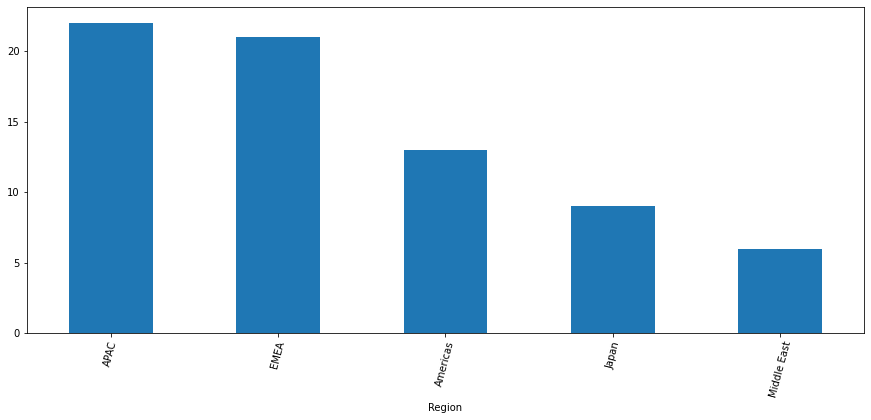

In [100]:
opportunitiesByFamily = data_frame.groupby(['Region']).agg({'Opportunity_Owner':pd.Series.nunique})
opportunitiesByFamily.columns = ['Opportunity_count']
opportunitiesByFamily.sort_values(by='Opportunity_count',ascending=False).plot.bar(legend=False,figsize=(15,6),rot=75)

In [105]:
data_frame['Source '].value_counts()

None         9497
Source_7     2965
Source_9     1459
Source_11    1421
Source_13     786
Source_3      418
Source_1      137
Source_10     106
Source_2       86
Source_4       43
Source_6       19
Source_0        7
Source_12       2
Source_5        1
Name: Source , dtype: int64

<AxesSubplot:title={'center':'cantidad de vendedores distintos por fuente de oportunidad'}, ylabel='Source'>

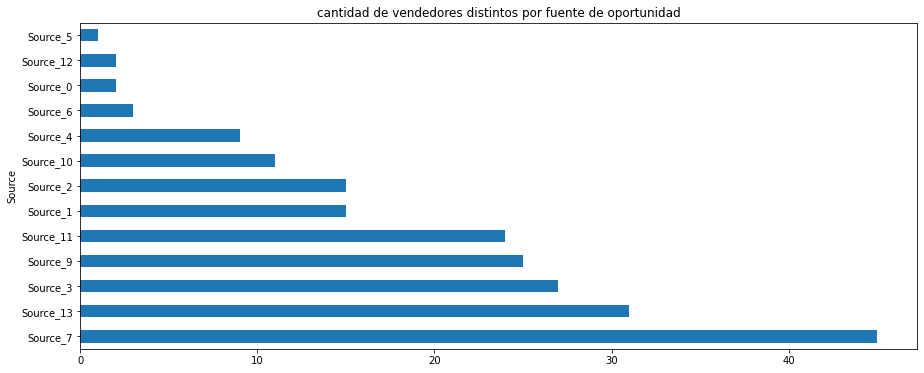

In [124]:
opportunitiesByFamily = data_frame.groupby(['Source ']).agg({'Opportunity_Owner':pd.Series.nunique}).reset_index().loc[1:,:]
opportunitiesByFamily.columns = ['Source','Opportunity_count']
opportunitiesByFamily.sort_values(by='Opportunity_count',ascending=False).plot.barh(x='Source',y='Opportunity_count',legend=False,figsize=(15,6),\
                                                                                  title='cantidad de vendedores distintos por fuente de oportunidad')

<AxesSubplot:title={'center':'Vendedores con mayor variedad de fuentes de venta'}, ylabel='Opportunity_Owner'>

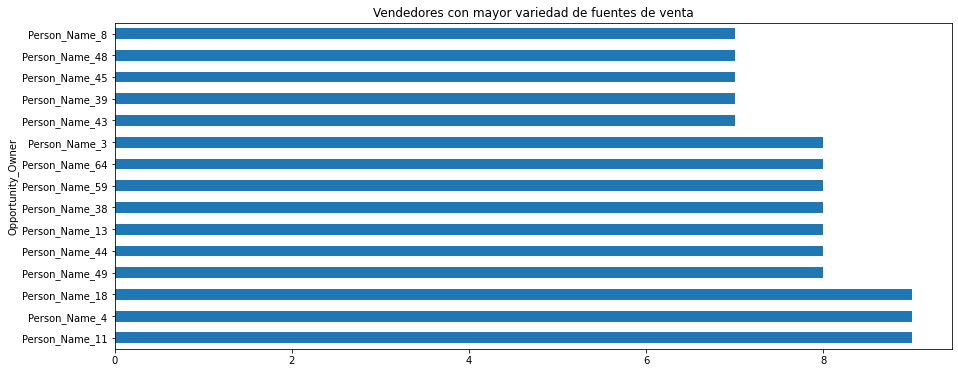

In [133]:
opportunitiesByFamily = data_frame.groupby(['Opportunity_Owner']).agg({'Source ':pd.Series.nunique}).reset_index().loc[1:,:]
opportunitiesByFamily.columns = ['Opportunity_Owner','Source_count']
opportunitiesByFamily.sort_values(by='Source_count',ascending=False).nlargest(15,'Source_count').plot.barh(x='Opportunity_Owner',y='Source_count',legend=False,figsize=(15,6),\
                                                                                  title='Vendedores con mayor variedad de fuentes de venta')